# INTRODUCTION
1. [Explore Data](#exp)
2. [Linear Regression and validation](#lin)
3. [Linear Regression with PCA and validation](#pca)        
4. [Residue and Homoscedasticity](#res)
5. [Analysis on models](#ana)
6. [Conclusion](#con)

This notebook does not focus on Data cleaning and Exploration but the code of models. The cleaning part is done in clean-Melbourne_housing_FULL-cleaned.csv.ipynb file.

# <a id="exp">1. Explore Data </a>

In [1]:
# import neccessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# show plot intermediately under the calling cell
%matplotlib inline

In [2]:
# read CSV files
df = pd.read_csv('Melbourne_housing_FULL-cleaned.csv')

#set pandas settings
pd.set_option('display.max_columns', None)

# disable some warnings
import warnings
warnings.simplefilter(action = "ignore")

## 1.1. Explore numberic data

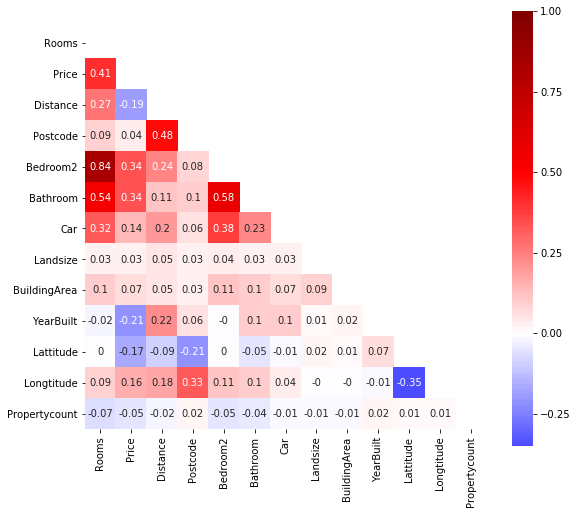

Bedroom2 and Rooms columns have highest correlation (0.84). They are likely to have multicollinearity if they exist in the same prediction model.

## 1.2. Explore Categorical data

In [4]:
# get brief describe of object-type columns to check whether 
# one-hot-encoding is needed or not.
df.describe(include='O')

,Suburb,Address,Type,Method,SellerG,Date,CouncilArea,Regionname
count,34837,34837,34837,34837,34837,34837,34835,34835
unique,350,33989,3,9,388,78,33,8
top,Reservoir,5 Charles St,h,S,Jellis,28/10/2017,Boroondara City Council,Southern Metropolitan
freq,844,6,23964,19736,3358,1116,3672,11827


3 columns has less than 10 unique data is "Type", "Method", "Regionname".

Create a table to count the unique data in those columns:

,Type category,Type counts,Method category,Method counts,Regionname category,Regionname counts
0,h,23964,S,19736,S,19736
1,u,7293,SP,5092,SP,5092
2,t,3580,PI,4845,PI,4845
3,None,None,VB,3105,VB,3105
4,None,None,SN,1316,SN,1316
5,None,None,PN,308,PN,308
6,None,None,SA,226,SA,226
7,None,None,W,173,W,173
8,None,None,SS,36,SS,36


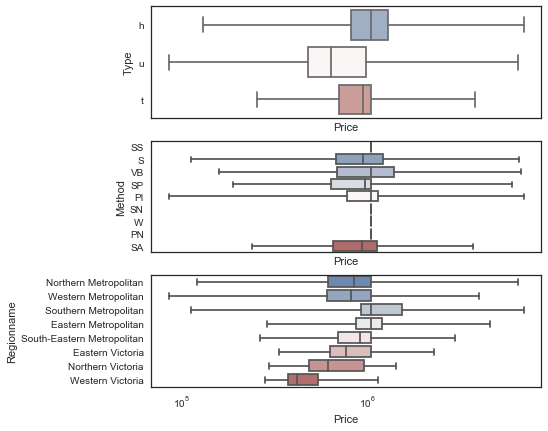

The chart gives a hint that Regionname and Type do effect Price, and some Methods have a constant Price.

## 1.3. Transform categorical data

For One-hot-encode tables, we create 3 separated figures.

In [7]:
# ty1df = Type One-hot-encode DF
ty1df = pd.get_dummies(df.Type)
# me1df = Method One-hot-encode DF
me1df = pd.get_dummies(df.Method)
# re1df = Regionname One-hot-encode DF
re1df = pd.get_dummies(df.Regionname)
onedf = pd.concat([ty1df,me1df,re1df], axis=1)

ty1df['Price'] = df.Price
me1df['Price'] = df.Price
re1df['Price'] = df.Price

onedf.head(2)

,h,t,u,PI,PN,S,SA,SN,SP,SS,VB,W,Eastern Metropolitan,Eastern Victoria,Northern Metropolitan,Northern Victoria,South-Eastern Metropolitan,Southern Metropolitan,Western Metropolitan,Western Victoria
0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


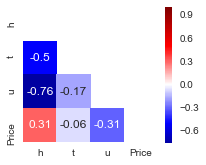

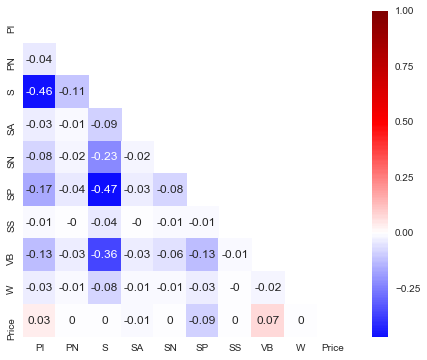

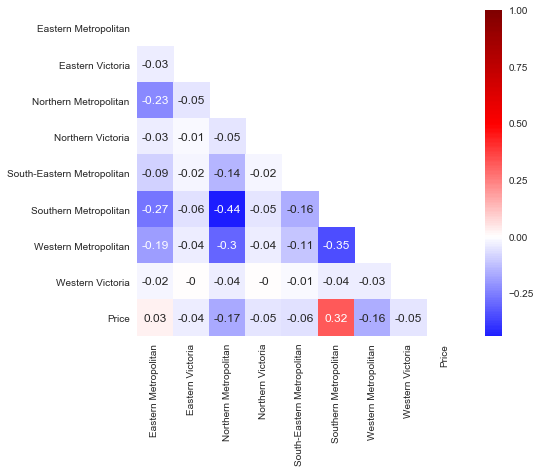

## 1.4. Feature selection

We choose these features to predict the __price__ of the house because:
- __Rooms__ : has highest correlation coefficient with Price (0.41)
- __Distance__ : has top negative correlation coefficient with Price (-0.19)
- __Bathroom__ : has top correlation coefficient with Price (0.34)
- __Bedroom2__ : has top correlation coefficient with Price (0.34)
- __YearBuilt__ : has top negative correlation coefficient with Price (-0.21)
- __Type__ : box chart and transformed correlation matrix show this might be clue to predict Price
- __Method__ : box chart shows that some Method has a constant price
- __Regionname__ : box chart and transformed correlation matrix show this might be clue to predict Price.

### IMPORTANT:
For the purpose of practicing, those features and Linear regression model are picked although the correlation between them (predictors) and Price is not high enough for Linear regression to be a good choice of prediction method.

## 1.5. Feature engineering
Because of feature scaling, new table of normalized data (in range [0,1]) is needed:

In [11]:
# pdf = Prediction DataFrame
pdf = pd.DataFrame([df.Rooms, df.Distance, df.Bedroom2, 
                    df.YearBuilt]).T
pdf.head(2)

,Rooms,Distance,Bedroom2,YearBuilt
0,2.0,2.5,2.0,1970.0
1,2.0,2.5,2.0,1970.0


In [12]:
from sklearn import preprocessing

# Normalize the pdf
# xdf = df for input X
min_max_scaler = preprocessing.MinMaxScaler()
xdf = min_max_scaler.fit_transform(pdf)
xdf = pd.DataFrame(xdf,columns=pdf.columns)
xdf = pd.concat([xdf, onedf],axis=1)
xdf.head(2)

,Rooms,Distance,Bedroom2,YearBuilt,h,t,u,PI,PN,S,SA,SN,SP,SS,VB,W,Eastern Metropolitan,Eastern Victoria,Northern Metropolitan,Northern Victoria,South-Eastern Metropolitan,Southern Metropolitan,Western Metropolitan,Western Victoria
0,0.111111,0.051975,0.2,0.70303,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,0.111111,0.051975,0.2,0.70303,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [13]:
# ys = Series for output Y
ys = df.Price
ys.head(2)

0    1.050173e+06
1    1.480000e+06
Name: Price, dtype: float64

# <a id="lin">2. Linear regression and validation</a>

## 2.1. Linear regression

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# prepare the train and test data.
x_train, x_test, y_train, y_test = train_test_split(xdf, ys, test_size=0.2,
                                                    random_state=25)
# Train the model
regr1 = linear_model.LinearRegression()
regr1.fit(x_train, y_train)

Intercept: -5.34955340664894e+17
Coefficients of predictors:


,Rooms,Distance,Bedroom2,YearBuilt,h,t,u,PI,PN,S,SA,SN,SP,SS,VB,W,Eastern Metropolitan,Eastern Victoria,Northern Metropolitan,Northern Victoria,South-Eastern Metropolitan,Southern Metropolitan,Western Metropolitan,Western Victoria
0,1.576256e+06,-1.440609e+06,309451.481577,-221406.208116,4.864146e+17,4.864146e+17,4.864146e+17,4.854071e+16,4.854071e+16,4.854071e+16,4.854071e+16,4.854071e+16,4.854071e+16,4.854071e+16,4.854071e+16,4.854071e+16,228800.0,464664.0,7040.0,348712.0,356416.0,394976.0,-37568.0,143244.0


## 2.2. Validation

### 2.2.1. _Hold-out_

In [15]:
from sklearn.metrics import mean_squared_error

# predict the Price from test sample and get Root Mean Squared Error.
y_pred1 = regr1.predict(x_test)
print("Root mean squared error: ",
      mean_squared_error(y_test, y_pred1)**0.5)

Root mean squared error:  423270.1284498522


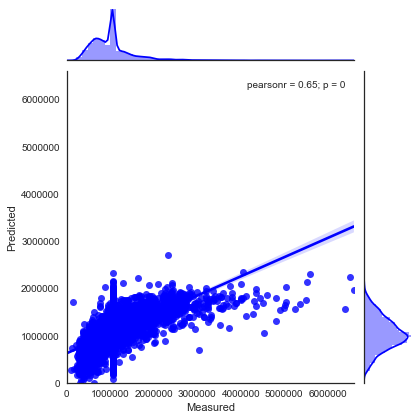

In [16]:
# cvdf = Cross Validation DataFrame
cvdf = pd.DataFrame({'Measured':y_test, 
                     'Predicted':y_pred1})
sns.jointplot("Measured", "Predicted", data=cvdf, kind="reg", color="b",
              xlim=(0, max(y_pred1.max(),y_test.max())),
              ylim=(0, max(y_pred1.max(),y_test.max())))
plt.show()

### 2.2.2. _cross validation_

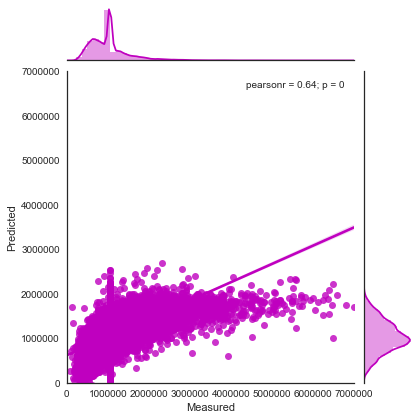

In [17]:
from sklearn.model_selection import cross_val_predict

regr2 = linear_model.LinearRegression()
# regr2.fit(xdf, ys)
measured2 = ys
predicted2 = cross_val_predict(regr2, xdf, ys, cv=10)

# cvdf = Cross Validation DataFrame
cvdf2 = pd.DataFrame({'Measured':ys, 
                     'Predicted':predicted2})
sns.jointplot("Measured", "Predicted", data=cvdf2, kind="reg", color="m", 
              xlim=(0, max(ys.max(), predicted2.max())),
              ylim=(0, max(ys.max(), predicted2.max())))
plt.show()

The linear regression line made by Measured and Predicted is way below the 45-degree line (indicates that Measure = Predicted), so the model tends to predict lower value than the real measured data.

In [18]:
# y_pred2 = regr2.predict(x_test)
print("Root mean squared error: ", 
      mean_squared_error(measured2, predicted2)**0.5)

Root mean squared error:  430774.6681988688


# <a id="pca">3. Linear Regression with PCA and validation </a>

## 3.1. PCA

In [20]:
# Cumulative explained variance:
pd.DataFrame([cum_var_exp], columns=["dim {}".format(i)
                    for i in range(1, len(xdf.columns)+1)])

,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9,dim 10,dim 11,dim 12,dim 13,dim 14,dim 15,dim 16,dim 17,dim 18,dim 19,dim 20,dim 21,dim 22,dim 23,dim 24
0,0.199872,0.363755,0.515696,0.627913,0.705595,0.778058,0.845071,0.897558,0.930782,0.95397,0.965634,0.972514,0.978479,0.98424,0.988017,0.99125,0.994099,0.996878,0.998723,0.999396,0.999996,1.0,1.0,1.0


So if we reduce the number of dimensions to 10, the cumulative explained variance is 0.95, which is acceptable.

In [21]:
# create a PCA to reduce dimension to n
n = 10
pca = PCA(n_components=n)
# put data (predictor only) to pca and create pcadf
pcadf = pd.DataFrame(pca.fit_transform(xdf))

# prepare the train and test data.
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(
                        pcadf, ys, test_size=0.2, random_state=50)
# Train the model
regr3=linear_model.LinearRegression()
regr3.fit(x_train_pca, y_train_pca)

# print result
print('Intercept:',regr3.intercept_.round(4))
print('Coefficients of predictors:')

Intercept: 1048942.5414
Coefficients of predictors:


,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9,dim 10
0,-120308.9111,-62805.6833,-433304.756,-310736.7395,32871.36,-59639.8531,96173.3428,71340.2989,-239260.9952,-80345.5835


## 3.2. Validation

### 3.2.1. _Hold-out_

In [22]:
y_pred3 = regr3.predict(x_test_pca)
print("Root mean squared error: ", 
      mean_squared_error(y_test_pca, y_pred3)**0.5)

Root mean squared error:  475477.11781811


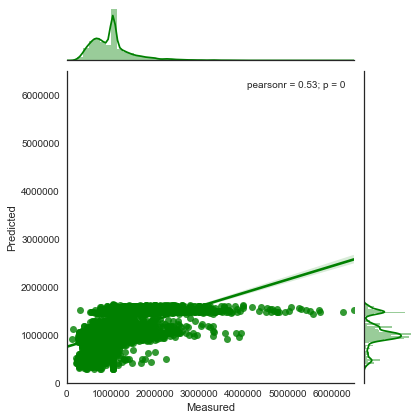

In [23]:
# cvdf = Cross Validation DataFrame
cvdf = pd.DataFrame({'Measured':y_test_pca, 
                     'Predicted':y_pred3})
sns.jointplot("Measured", "Predicted", data=cvdf, kind="reg", color="g",
              xlim=(0, max(y_pred3.max(),y_test_pca.max())),
              ylim=(0, max(y_pred3.max(),y_test_pca.max())))
plt.show()

### 3.2.2. Cross validation

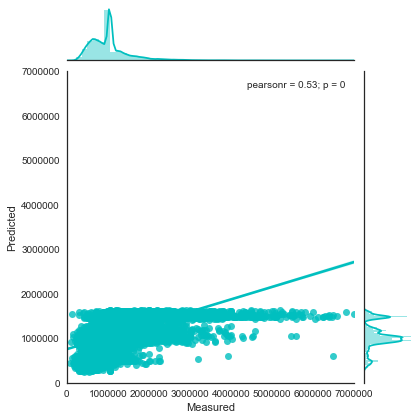

In [24]:
regr4 = linear_model.LinearRegression()
regr4.fit(x_train_pca, y_train_pca)
measured4 = ys
predicted4 = cross_val_predict(regr4, pcadf, ys, cv=10)

# cvdf = Cross Validation DataFrame
cvdf = pd.DataFrame({'Measured' : measured4, 
                     'Predicted' : predicted4})
sns.jointplot("Measured", "Predicted", data=cvdf, kind="reg", color="c",
              xlim=(0, max(measured4.max(), predicted4.max())),
              ylim=(0, max(measured4.max(), predicted4.max())))
plt.show()

The linear regression line made by Measured and Predicted is way below the 45-degree line (indicates that Measure = Predicted), so the model tends to predict lower value than the real measured data.

In [25]:
# y_pred4 = regr4.predict(x_test)
print("Root mean squared error: ", 
      mean_squared_error(measured4, predicted4)**0.5)

Root mean squared error:  475814.78723489225


# <a id="res">4. Residues and Homoscedasticity </a>

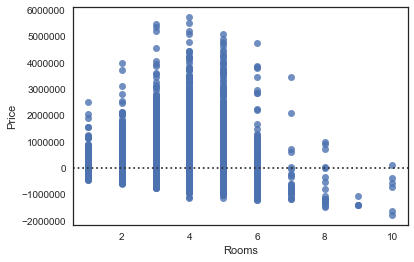

In [26]:
# residue
sns.residplot(df.Rooms, df.Price)
plt.show()
# To-do: find better visualizer for multi-varables LR
# To-do: find a way to plot heteroscedasticity

# <a id="tun">5. Analyze the models</a>

Through out the process, I had to re-clean the data many times to eliminate the outliers which tremendously effect the outcome linear regression function. This model also has to deal with many problems like multicollinearity, heteroscedasticity, so it tends to overfit the data, make the prediction inaccurate dues to sample picked. And the uppermost reason make the model prediction is bad because the correlation of data to Price is not high enough.

PCA helps to eliminate the multicolinearity (in this case is the bond between Rooms and Bedroom2 - correlation is 0.84) by reducing the dimension so the redundant dimensions have less affect on the outcome of the model.

It PCA makes the model less overfitting but increase the RMSE. RMSE of models:
- No PCA, Hold-out: 423270.128
- No PCA, Cross validation: 430774.668
- PCA, Hold-out: 475477.117
- PCA, Cross validation: 475814.787

The comparison between Hold-out and Cross validation is invalid because they based on different numbers of checking sample: Hold-out check test samples, cross-validation check the whole data.

# <a id="con">6. Conclusion</a>

From the analyzed data, we grasp the idea that the Rooms and Bedroom2 has positive affect on the Price, reversely, the Distance and Yearbuilt tend to reduce the house's price.

The model (even after applied PCA) is not ideal to predict the price, using 8 picked features.